In [ ]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Paths to training folders
base_path = '/content/drive/MyDrive/ml'  # Update this path
train_dir = os.path.join(base_path, 'train')

# Parameters for image processing
image_size = (128, 128)
categories = ['autistic', 'non_autistic']

def load_and_preprocess_images(data_dir):
    data = []
    labels = []
    for category in categories:
        class_dir = os.path.join(data_dir, category)
        class_label = categories.index(category)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, image_size)
                img = img / 255.0
                data.append(img)
                labels.append(class_label)
    return np.array(data), np.array(labels)

# Load and preprocess data
train_data, train_labels = load_and_preprocess_images(train_dir)

# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Define and compile the CNN model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
x = Flatten()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

cnn_model = Model(inputs=base_model.input, outputs=output)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Extract features from the CNN
feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)  # Extract from the second last layer
features_train = feature_extractor.predict(X_train)
features_val = feature_extractor.predict(X_val)

# Reshape features for XGBoost (2D array)
features_train = features_train.reshape(features_train.shape[0], -1)
features_val = features_val.reshape(features_val.shape[0], -1)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 52s 667ms/step - accuracy: 0.6519 - loss: 1.1956 - val_accuracy: 0.6590 - val_loss: 1.2690
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 85s 714ms/step - accuracy: 0.7763 - loss: 0.8794 - val_accuracy: 0.7395 - val_loss: 0.7875
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 78s 654ms/step - accuracy: 0.8208 - loss: 0.5705 - val_accuracy: 0.7625 - val_loss: 0.7791
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 88s 743ms/step - accuracy: 0.8531 - loss: 0.4608 - val_accuracy: 0.7471 - val_loss: 0.9058
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 78s 692ms/step - accuracy: 0.9031 - loss: 0.3055 - val_accuracy: 0.7395 - val_loss: 0.9449
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 716ms/step - accuracy: 0.9037 - loss: 0.2742 - val_accuracy: 0.7510 - val_loss: 0.8738
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 626ms/step - accuracy: 0.8989 - loss: 0.2953 - val_accuracy: 0.7107 - val_loss: 1.5630
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 86s 679ms/

In [ ]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(features_train, y_train)

# Evaluate the model
xgb_accuracy = xgb_model.score(features_val, y_val)
print(f"XGBoost Validation Accuracy: {xgb_accuracy * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:48:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Validation Accuracy: 76.25%


In [ ]:
# Get predictions from CNN
cnn_predictions = cnn_model.predict(X_val)
cnn_predictions_classes = np.argmax(cnn_predictions, axis=1)

# Get predictions from XGBoost
xgb_predictions = xgb_model.predict(features_val)

# Combine predictions (simple averaging or majority voting)
combined_predictions = []
for cnn_pred, xgb_pred in zip(cnn_predictions_classes, xgb_predictions):
    # Majority voting
    combined_pred = np.round((cnn_pred + xgb_pred) / 2)
    combined_predictions.append(int(combined_pred))

# Calculate accuracy of combined predictions
combined_accuracy = np.mean(combined_predictions == y_val)
print(f"Combined Model Validation Accuracy: {combined_accuracy * 100:.2f}%")


17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
Combined Model Validation Accuracy: 77.97%


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 849ms/step - accuracy: 0.5122 - loss: 2.5651 - val_accuracy: 0.5115 - val_loss: 0.6744
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 53s 784ms/step - accuracy: 0.5442 - loss: 0.6666 - val_accuracy: 0.6973 - val_loss: 0.5817
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 782ms/step - accuracy: 0.6447 - loss: 0.6168 - val_accuracy: 0.7107 - val_loss: 0.6176
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 85s 812ms/step - accuracy: 0.6463 - loss: 0.6011 - val_accuracy: 0.7069 - val_loss: 0.5678
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 54s 807ms/step - accuracy: 0.6953 - loss: 0.5758 - val_accuracy: 0.7337 - val_loss: 0.5880
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 845ms/step - accuracy: 0.6653 - loss: 0.5998 - val_accuracy: 0.7490 - val_loss: 0.5301
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 853ms/step - accuracy: 0.6843 - loss: 0.5840 - val_accuracy: 0.7529 - val_loss: 0.5297
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 91s 974ms/step - accuracy: 0.7243 - loss: 0.5504 - val_accuracy: 0.764

Test Accuracy: 82.00%
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 792ms/step


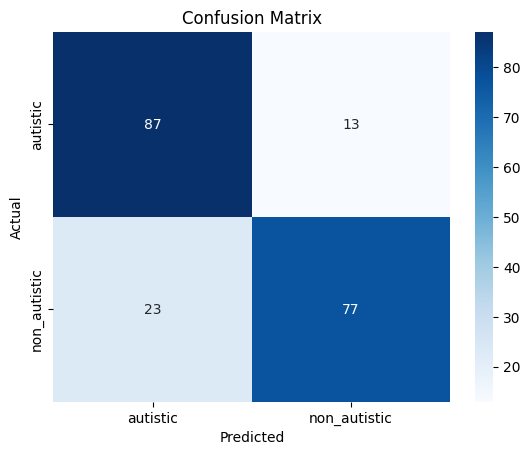

              precision    recall  f1-score   support

    autistic       0.79      0.87      0.83       100
non_autistic       0.86      0.77      0.81       100

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200



In [ ]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Paths to training and testing folders
base_path = '/content/drive/MyDrive/ml'  # Update this path
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')

# Parameters for image processing
image_size = (128, 128)  # Resize images to 128x128
categories = ['autistic', 'non_autistic']

def load_and_preprocess_images(data_dir):
    data = []
    labels = []
    for category in categories:
        class_dir = os.path.join(data_dir, category)
        class_label = categories.index(category)  # 0 for autistic, 1 for non_autistic
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, image_size)
                img = img / 255.0  # Normalize pixel values
                data.append(img)
                labels.append(class_label)
    return np.array(data), np.array(labels)

# Load and preprocess train and test data
train_data, train_labels = load_and_preprocess_images(train_dir)
test_data, test_labels = load_and_preprocess_images(test_dir)

# Split the training data further into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# One-hot encode labels
train_labels = to_categorical(train_labels, num_classes=2)
val_labels = to_categorical(val_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

# Define data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define model with MobileNetV2
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(datagen.flow(train_data, train_labels, batch_size=32),
                    validation_data=(val_data, val_labels),
                    epochs=10)

# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save the model
model.save("autism_detection_model.h5")

# Confusion Matrix and Classification Report
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=categories))


In [ ]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split

# Paths to training and testing folders
base_path = '/content/drive/MyDrive/ml'  # Update this path
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')

# Parameters for image processing
image_size = (128, 128)  # Resize images to 128x128
categories = ['autistic', 'non_autistic']

def load_and_preprocess_images(data_dir):
    data = []
    labels = []
    for category in categories:
        class_dir = os.path.join(data_dir, category)
        class_label = categories.index(category)  # 0 for autistic, 1 for non_autistic
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, image_size)
                img = img / 255.0  # Normalize pixel values
                data.append(img)
                labels.append(class_label)
    return np.array(data), np.array(labels)

# Load and preprocess train and test data
train_data, train_labels = load_and_preprocess_images(train_dir)
test_data, test_labels = load_and_preprocess_images(test_dir)

# Split the training data further into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# One-hot encode labels
train_labels = to_categorical(train_labels, num_classes=2)
val_labels = to_categorical(val_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

# Define model with MobileNetV2
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=10, batch_size=32)


# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


# Save the model
model.save("autism_detection_model.h5")

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 52s 692ms/step - accuracy: 0.6308 - loss: 2.0926 - val_accuracy: 0.7759 - val_loss: 0.5012
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 680ms/step - accuracy: 0.7541 - loss: 0.4898 - val_accuracy: 0.7625 - val_loss: 0.4813
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 692ms/step - accuracy: 0.7892 - loss: 0.4309 - val_accuracy: 0.7433 - val_loss: 0.4809
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 84s 722ms/step - accuracy: 0.8135 - loss: 0.3832 - val_accuracy: 0.7567 - val_loss: 0.4688
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 740ms/step - accuracy: 0.8417 - loss: 0.3536 - val_accuracy: 0.7625 - val_loss: 0.4823
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 89s 852ms/step - accuracy: 0.8029 - loss: 0.3456 - val_accuracy: 0.7701 - val_loss: 0.4713
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 72s 689ms/step - accuracy: 0.8551 - loss: 0.3020 - val_accuracy: 0.7586 - val_loss: 0.4994
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 85s 741ms/step - accuracy: 0.8492 - loss: 0.2917 - val_accu

Test Accuracy: 85.50%


In [ ]:
import matplotlib.pyplot as plt  # Importing matplotlib for plotting
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split


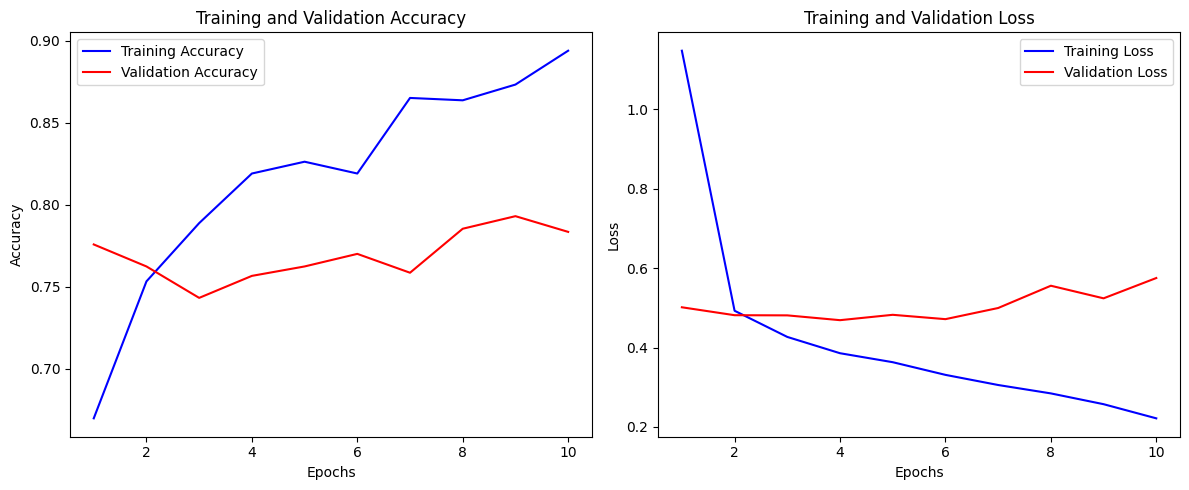

In [ ]:
# Plotting training & validation accuracy and loss
epochs = range(1, len(history.history['accuracy']) + 1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

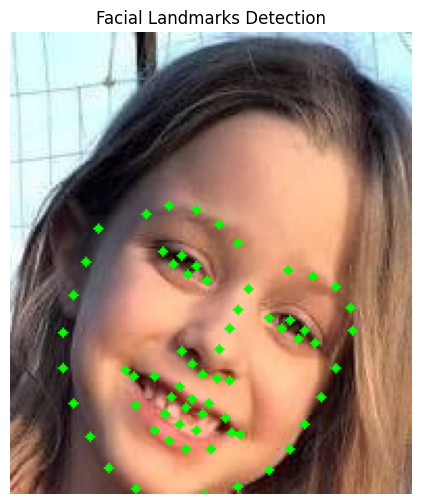

In [ ]:
import cv2
import dlib
import matplotlib.pyplot as plt

# Load pre-trained models
detector = dlib.get_frontal_face_detector()  # Face detector
predictor = dlib.shape_predictor('/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat')  # Landmark predictor

def detect_facial_landmarks(image_path):
    # Read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for plotting

    # Detect faces in the image
    faces = detector(image)
    for face in faces:
        # Predict landmarks
        landmarks = predictor(image, face)

        # Draw landmarks
        for n in range(68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

    # Display the image
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Facial Landmarks Detection")
    plt.show()

# Provide the path to your image
detect_facial_landmarks("/content/drive/MyDrive/ml/train/autistic/0956.jpg")


In [ ]:
# Load required libraries
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("autism_detection_model.h5")

# Parameters for image processing
image_size = (128, 128)  # Same size as during training
categories = ['Autistic', 'Non_Autistic']  # Define the categories

def preprocess_image(img_path):
    """
    Preprocesses the image to the required format before prediction.
    """
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, image_size)  # Resize the image
        img = img / 255.0  # Normalize the pixel values
        img = np.expand_dims(img, axis=0)  # Expand dimensions to match model input
        return img
    else:
        print("Error: Image not found or invalid format.")
        return None

def predict_image(img_path):
    """
    Predicts whether the input image is 'autistic' or 'non_autistic'.
    """
    img = preprocess_image(img_path)
    if img is not None:
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)  # Get the index of the highest probability
        confidence = np.max(prediction)  # Get the confidence of the prediction
        print(f"Predicted Class: {categories[predicted_class]} with confidence {confidence * 100:.2f}%")
    else:
        print("Failed to preprocess image.")

# Test the prediction function with an image path
img_path = '/content/drive/MyDrive/ml/train/autistic/0002.jpg'  # Replace with the actual image path
predict_image(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Autistic with confidence 99.87%


In [ ]:
# Load required libraries
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("autism_detection_model.h5")

# Parameters for image processing
image_size = (128, 128)  # Same size as during training
categories = ['Autistic', 'Non_Autistic']  # Define the categories

def preprocess_image(img_path):
    """
    Preprocesses the image to the required format before prediction.
    """
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, image_size)  # Resize the image
        img = img / 255.0  # Normalize the pixel values
        img = np.expand_dims(img, axis=0)  # Expand dimensions to match model input
        return img
    else:
        print("Error: Image not found or invalid format.")
        return None

def predict_image(img_path):
    """
    Predicts whether the input image is 'autistic' or 'non_autistic'.
    """
    img = preprocess_image(img_path)
    if img is not None:
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)  # Get the index of the highest probability
        confidence = np.max(prediction)  # Get the confidence of the prediction
        print(f"Predicted Class: {categories[predicted_class]} with confidence {confidence * 100:.2f}%")
    else:
        print("Failed to preprocess image.")

# Test the prediction function with an image path
img_path = '/content/drive/MyDrive/ml/train/non_autistic/0003.jpg'  # Replace with the actual image path
predict_image(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: Non_Autistic with confidence 99.86%


In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
confidence_threshold = 0.5  # Try lowering the threshold to 0.5

def gradio_predict(image):
    if image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

    img = cv2.resize(image, image_size) / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    predicted_class_index = np.argmax(prediction)
    confidence = np.max(prediction)

    if confidence < confidence_threshold:
        return "Prediction is uncertain (Confidence below threshold)"
    else:
        predicted_class = categories[predicted_class_index]
        return f"{predicted_class} (Confidence: {confidence * 100:.2f}%)"


In [ ]:
# Import required libraries
import numpy as np
import cv2
import gradio as gr
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('autism_detection_model.h5')
categories = ['Autistic', 'Non_Autistic']
image_size = (128, 128)  # Image size used during training

def preprocess_image(img_path):
    """
    Preprocesses the image from a given path for prediction.
    """
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, image_size)  # Resize the image
        img = img / 255.0  # Normalize the pixel values
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        return img
    else:
        print("Error: Image not found or invalid format.")
        return None

def predict_image(img_path):
    """
    Predicts whether the input image is 'autistic' or 'non_autistic' from a file path.
    """
    img = preprocess_image(img_path)
    if img is not None:
        prediction = model.predict(img)
        predicted_class = categories[np.argmax(prediction)]  # Get the predicted class
        confidence = np.max(prediction)  # Get the confidence of the prediction
        print(f"Predicted Class: {predicted_class} with confidence {confidence * 100:.2f}%")
    else:
        print("Failed to preprocess image.")

# Test the function with a sample image path
img_path = '/content/drive/MyDrive/ml/train/non_autistic/0003.jpg'  # Replace with the actual image path
predict_image(img_path)
# Gradio Prediction Function
def gradio_predict(image):
    # Convert image to RGB if it has an alpha channel
    if image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

    # Preprocess the image
    img = cv2.resize(image, image_size) / 255.0  # Resize and normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img)
    predicted_class = categories[np.argmax(prediction)]  # Get the predicted class
    confidence = np.max(prediction)  # Get the confidence of the prediction

    return f"{predicted_class} (Confidence: {confidence * 100:.2f}%)"  # Return the result

# Create the Gradio interface
iface = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Image(type="numpy"),  # Image input type set to numpy array
    outputs=gr.Text(),               # Text output to display the prediction
    title="Autism Detection Model",
    description="Upload an image to see if it is autistic or non-autistic."
)

# Launch the Gradio interface
iface.launch()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Non_Autistic with confidence 99.86%
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3e4c6de0bdc325f4d1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import numpy as np
import cv2
import gradio as gr
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('autism_detection_model.h5')
categories = ['Autistic', 'Non_Autistic']
def predict(image):
    img = cv2.resize(image, (128, 128)) / 255.0  # Resize and normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    # Make prediction
    prediction = model.predict(img)
    predicted_class = categories[np.argmax(prediction)]  # Get the predicted class
    confidence = np.max(prediction)  # Get the confidence of the prediction
    return f"{predicted_class} (Confidence: {confidence:.2f})"  # Return the result
# Create the Gradio interface
iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),  # Image input type is set to numpy array
    outputs=gr.Text(),               # Text output to display the prediction
    title="Autism Detection Model",
    description="Upload an image to see if it is autistic or non-autistic."
)
iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c963b871737cb250e4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
